# 1. Carga de datos
En esta sección se cargan todos los archivos necesarios para el análisis y construcción de los modelos de recomendación. Cada archivo contiene información relevante sobre juegos, usuarios, ratings, mecánicas, diseñadores, publishers, subcategorías, distribución de ratings y temas.

In [1]:
import pandas as pd

df_games = pd.read_csv("games.csv")
df_designers_reduced = pd.read_csv("designers_reduced.csv")
df_mechanics = pd.read_csv("mechanics.csv")
df_publishers_reduced = pd.read_csv("publishers_reduced.csv")
df_subcategories = pd.read_csv("subcategories.csv")
df_ratings_distribution = pd.read_csv("ratings_distribution.csv")
df_user_ratings = pd.read_csv("user_ratings.csv")
df_artists_reduced = pd.read_csv("artists_reduced.csv")
df_themes = pd.read_csv("themes.csv")

# 2. Utilidades y funciones auxiliares
Se definen funciones y utilidades generales para el procesamiento de datos, manejo de splits y métricas.

In [2]:
# === Imports y utils ===
import time, re, random, math
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

from surprise import Dataset, Reader, NormalPredictor

def _fmt_secs(s):
    if s < 60: return f"{s:.1f}s"
    m, s = divmod(int(s), 60)
    if m < 60: return f"{m}m {s}s"
    h, m = divmod(m, 60); return f"{h}h {m}m"

def _eta(start_t, done, total):
    elapsed = time.time() - start_t
    if done == 0: return "?"
    rate = elapsed / done
    remain = rate * (total - done)
    return _fmt_secs(remain)

In [3]:
# === Split hold-out por usuario (80/20) con progreso ===
def make_holdout_by_user(df_user_ratings, rating_scale=(1,10), test_frac=0.2, min_per_user=3, seed=42, log_every=10_000):
    rng = np.random.default_rng(seed)
    df = df_user_ratings.copy()
    df["Username"] = df["Username"].astype(str)
    df["BGGId"] = df["BGGId"].astype(str)

    # filtrar usuarios con suficientes interacciones
    counts = df.groupby("Username")["BGGId"].count()
    keep_users = counts[counts >= min_per_user].index
    df = df[df["Username"].isin(keep_users)].reset_index(drop=True)

    # split por usuario
    train_rows, test_rows = [], []
    user_groups = df.groupby("Username", sort=False)
    total_users = len(user_groups)
    print(f"[Split] Usuarios a procesar: {total_users:,}")
    t0 = time.time()

    for idx, (uid, g) in enumerate(user_groups, 1):
        idxs = rng.permutation(len(g))
        n_test = max(1, int(round(test_frac * len(g))))
        test_idx = set(idxs[:n_test])
        for i, row in enumerate(g.itertuples(index=False)):
            (test_rows if i in test_idx else train_rows).append(row)

        if idx % log_every == 0:
            elapsed = time.time() - t0
            print(f"[Split] {idx:,}/{total_users:,} usuarios ({idx/total_users:>.1%}) | "
                  f"elapsed {_fmt_secs(elapsed)} | ETA {_eta(t0, idx, total_users)}")

    train_df = pd.DataFrame(train_rows, columns=df.columns)
    test_df  = pd.DataFrame(test_rows,  columns=df.columns)

    # Surprise trainset
    data = Dataset.load_from_df(train_df[["Username","BGGId","Rating"]], Reader(rating_scale=rating_scale))
    trainset = data.build_full_trainset()

    # testset como lista de tuplas (uid,iid,r)
    testset = list(test_df[["Username","BGGId","Rating"]].itertuples(index=False, name=None))

    print(f"[Split] Usuarios: {trainset.n_users:,} | Ítems: {trainset.n_items:,} | "
          f"Train inter.: {trainset.n_ratings:,} | Test inter.: {len(testset):,}")
    print(f"[Split] Hecho en {_fmt_secs(time.time()-t0)}")
    return trainset, testset, train_df, test_df

In [4]:
# === Candidatos por usuario ===
def build_eval_candidates(trainset, testset, n_neg=100, seed=42, log_every=10_000):
    print("[Candidates] Construyendo candidatos...")
    t0 = time.time()
    random.seed(seed)

    heldout = defaultdict(list)
    for uid_raw, iid_raw, _ in testset:
        heldout[uid_raw].append(iid_raw)

    all_items_inner = set(trainset.all_items())
    seen_by_u = {u: set(j for (j, _) in trainset.ur[u]) for u in trainset.all_users()}

    cands = {}
    total_u = trainset.n_users
    for idx, u_inner in enumerate(trainset.all_users(), 1):
        uid_raw = trainset.to_raw_uid(u_inner)
        not_seen = list(all_items_inner - seen_by_u[u_inner])
        neg_sample = random.sample(not_seen, min(n_neg, len(not_seen)))
        cand = set(trainset.to_raw_iid(j) for j in neg_sample)
        for iid in heldout.get(uid_raw, []):
            cand.add(iid)
        cands[uid_raw] = cand

        if idx % log_every == 0:
            print(f"[Candidates] {idx:,}/{total_u:,} ({idx/total_u:>.1%}) | "
                  f"elapsed {_fmt_secs(time.time()-t0)} | ETA {_eta(t0, idx, total_u)}")

    print(f"[Candidates] Listo en {_fmt_secs(time.time()-t0)} "
          f"(usuarios={total_u:,}, items={trainset.n_items:,})")
    return cands, heldout

In [5]:
# === Métricas de ranking ===
def precision_recall_ndcg_map_mrr_at_k(topn, heldout, k=10):
    precisions, recalls, ndcgs, aps, rrs = [], [], [], [], []

    for uid, rel_items in heldout.items():
        rel = set(rel_items)
        recs = topn.get(uid, [])[:k]

        # Precision / Recall
        hits_positions = [i for i, iid in enumerate(recs) if iid in rel]
        n_hits = len(hits_positions)
        precisions.append(n_hits / max(1, k))
        recalls.append(n_hits / max(1, len(rel)))

        # nDCG
        dcg = sum(1.0 / np.log2(i+2) for i in hits_positions)
        idcg = sum(1.0 / np.log2(i+2) for i in range(min(len(rel), k)))
        ndcgs.append(dcg / idcg if idcg > 0 else 0.0)

        # AP@K
        cum_hits, ap = 0, 0.0
        for r, iid in enumerate(recs, start=1):
            if iid in rel:
                cum_hits += 1
                ap += cum_hits / r
        aps.append(ap / min(len(rel), k) if len(rel) > 0 else 0.0)

        # MRR@K
        first = min(hits_positions) if hits_positions else None
        rrs.append(1.0 / (first+1) if first is not None else 0.0)

    return {
        "Precision@K": float(np.mean(precisions)) if precisions else 0.0,
        "Recall@K":    float(np.mean(recalls))    if recalls    else 0.0,
        "nDCG@K":      float(np.mean(ndcgs))      if ndcgs      else 0.0,
        "MAP@K":       float(np.mean(aps))        if aps        else 0.0,
        "MRR@K":       float(np.mean(rrs))        if rrs        else 0.0,
    }

# 3. Modelos de recomendación
Implementación de modelos de recomendación.

## 3.0 Funciones de entrenamiento y ranking

### 3.0.1 BaseLines

In [6]:
# === Baseline: Most Popular ===
def most_popular_sorted(trainset, log_every=2_000_000):
    print("[MostPopular] Contando interacciones en train...")
    t0 = time.time()
    cnt = Counter()
    total = trainset.n_ratings
    done = 0
    for (u, i, _) in trainset.all_ratings():
        cnt[trainset.to_raw_iid(i)] += 1
        done += 1
        if done % log_every == 0:
            print(f"[MostPopular] {done:,}/{total:,} ({done/total:>.1%}) | ETA {_eta(t0, done, total)}")
    popular = [iid for iid,_ in cnt.most_common()]
    print(f"[MostPopular] Hecho en {_fmt_secs(time.time()-t0)}.")
    return popular

def topn_popular_from_candidates(popular_sorted, cands_by_u, n=10, log_every=10000):
    print("[MostPopular] Generando Top-N...")
    t0 = time.time()
    topn = {}
    users = list(cands_by_u.keys())
    total = len(users)
    for idx, uid in enumerate(users, 1):
        cand = cands_by_u[uid]
        ordered = [iid for iid in popular_sorted if iid in cand]
        topn[uid] = ordered[:n]
        if idx % log_every == 0:
            print(f"[MostPopular] {idx:,}/{total:,} ({idx/total:>.1%}) | ETA {_eta(t0, idx, total)}")
    print(f"[MostPopular] Listo en {_fmt_secs(time.time()-t0)}.")
    return topn

# === Baseline: Random ===
def topn_from_predictions(predictions, n=10):
    topn = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        topn[uid].append((iid, est))
    for uid, lst in topn.items():
        lst.sort(key=lambda x: x[1], reverse=True)
        topn[uid] = [iid for iid,_ in lst[:n]]
    return topn

def random_topn(trainset, candidates_by_user, n=10, log_every=10000):
    print("[Random] Entrenando NormalPredictor...")
    t0 = time.time()
    algo = NormalPredictor().fit(trainset)
    print(f"[Random] Entrenamiento: {_fmt_secs(time.time()-t0)}")

    print("[Random] Prediciendo...")
    t1 = time.time()
    preds = []
    users = list(candidates_by_user.keys())
    total_u = len(users)
    for ui, uid in enumerate(users, 1):
        items = candidates_by_user[uid]
        preds.extend([algo.predict(uid, iid) for iid in items])
        if ui % log_every == 0:
            print(f"[Random] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t1, ui, total_u)}")
    print(f"[Random] Predicción: {_fmt_secs(time.time()-t1)}")

    print("[Random] Top-N...")
    t2 = time.time()
    out = topn_from_predictions(preds, n=n)
    print(f"[Random] Top-N: {_fmt_secs(time.time()-t2)}")
    return out

# === Baseline: Content-Based ===
from sklearn.feature_extraction.text import TfidfVectorizer

def build_cb_index(df_games, df_themes=None, max_features=60000):
    print("[CB] Preparando index...")
    t0 = time.time()
    games = df_games.copy()
    games["BGGId"] = games["BGGId"].astype(str)

    cat_cols = [c for c in games.columns if c.startswith("Cat:")]
    def cat_tokens(row):
        toks=[]
        for c in cat_cols:
            try:
                if int(row[c])==1:
                    toks.append("cat_"+c.split(":",1)[1].lower())
            except: pass
        return " ".join(toks)

    gamesX = games[["BGGId","Name","Description"]].copy()
    gamesX["cat_tok"] = games.apply(cat_tokens, axis=1).fillna("")

    if df_themes is not None:
        th = df_themes.copy()
        th["BGGId"] = th["BGGId"].astype(str)
        tcols = [c for c in th.columns if c!="BGGId"]
        def norm(s): 
            s = s.lower(); s = re.sub(r"[^a-z0-9]+","_",s); return re.sub(r"_+","_",s).strip("_")
        def th_tokens(row):
            toks=[]
            for c in tcols:
                try:
                    if int(row[c])==1:
                        toks.append("theme_"+norm(c))
                except: pass
            return " ".join(toks)
        themes_tok = th[["BGGId"]].copy()
        themes_tok["theme_tok"] = th.apply(th_tokens, axis=1)
        gamesX = gamesX.merge(themes_tok, on="BGGId", how="left")
        gamesX["theme_tok"] = gamesX["theme_tok"].fillna("")
    else:
        gamesX["theme_tok"] = ""

    for col in ["Description","cat_tok","theme_tok"]:
        gamesX[col] = gamesX[col].fillna("")
    gamesX["desc_plus"] = (gamesX["Description"]+" "+gamesX["cat_tok"]+" "+gamesX["theme_tok"]).str.strip()

    vec = TfidfVectorizer(max_features=max_features, ngram_range=(1,2), stop_words="english")
    X = vec.fit_transform(gamesX["desc_plus"])

    iid2row = {iid:i for i,iid in enumerate(gamesX["BGGId"].tolist())}
    row2iid = {i:iid for iid,i in iid2row.items()}
    print(f"[CB] Index listo en {_fmt_secs(time.time()-t0)} | X={X.shape}")
    return {"vec":vec,"X":X,"iid2row":iid2row,"row2iid":row2iid,"gamesX":gamesX}

def cb_topn_from_candidates(trainset, cands_by_u, cb_index, fallback_pop=None, n=10, log_every=10000):
    print("[CB] Top-N por similitud...")
    t0 = time.time()
    X = cb_index["X"]; iid2row = cb_index["iid2row"]; row2iid = cb_index["row2iid"]
    topn = {}
    total_u = trainset.n_users
    for idx, u_inner in enumerate(trainset.all_users(), 1):
        uid = trainset.to_raw_uid(u_inner)
        items = [j for (j,_) in trainset.ur[u_inner]]
        rows = [iid2row.get(trainset.to_raw_iid(j)) for j in items]
        rows = [r for r in rows if r is not None]
        if not rows:
            if fallback_pop is not None:
                cand = cands_by_u.get(uid, set())
                topn[uid] = [iid for iid in fallback_pop if iid in cand][:n]
            else:
                topn[uid] = []
        else:
            prof = X[rows].mean(axis=0)
            cand = cands_by_u.get(uid, set())
            cand_rows = [iid2row[iid] for iid in cand if iid in iid2row]
            if not cand_rows:
                topn[uid] = []
            else:
                scores = (X[cand_rows] @ prof.T).A.ravel()
                order = np.argsort(-scores)[:n]
                topn[uid] = [row2iid[cand_rows[i]] for i in order]

        if idx % log_every == 0:
            print(f"[CB] {idx:,}/{total_u:,} ({idx/total_u:>.1%}) | ETA {_eta(t0, idx, total_u)}")
    print(f"[CB] Listo en {_fmt_secs(time.time()-t0)}.")
    return topn


### 3.0.2 Propuestas

In [7]:
# === iKNN ===
from surprise import KNNBasic

def iknn_topn(trainset, cands_by_u, n=10, sim_name='pearson', user_based=False, log_every=10000):
    print("[iKNN] Entrenando item-based KNN...")
    t0 = time.time()
    sim_options = {'name': sim_name, 'user_based': user_based}
    algo = KNNBasic(sim_options=sim_options).fit(trainset)
    print(f"[iKNN] Entrenamiento: {_fmt_secs(time.time()-t0)}")

    print("[iKNN] Prediciendo...")
    t1 = time.time()
    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)
    for ui, uid in enumerate(users, 1):
        items = cands_by_u[uid]
        preds.extend([algo.predict(uid, iid) for iid in items])
        if ui % log_every == 0:
            print(f"[iKNN] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t1, ui, total_u)}")
    print(f"[iKNN] Predicción: {_fmt_secs(time.time()-t1)}")

    print("[iKNN] Top-N...")
    t2 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[iKNN] Top-N: {_fmt_secs(time.time()-t2)}")
    return topn

# === SVD ===
from surprise import SVD

def svd_topn(trainset, cands_by_u, n=10, n_factors=50, n_epochs=20, random_state=42, log_every=10000):
    print("[SVD] Entrenando SVD...")
    t0 = time.time()
    algo = SVD(n_factors=n_factors, n_epochs=n_epochs, random_state=random_state).fit(trainset)
    print(f"[SVD] Entrenamiento: {_fmt_secs(time.time()-t0)}")

    print("[SVD] Prediciendo...")
    t1 = time.time()
    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)
    for ui, uid in enumerate(users, 1):
        items = cands_by_u[uid]
        preds.extend([algo.predict(uid, iid) for iid in items])
        if ui % log_every == 0:
            print(f"[SVD] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t1, ui, total_u)}")
    print(f"[SVD] Predicción: {_fmt_secs(time.time()-t1)}")

    print("[SVD] Top-N...")
    t2 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[SVD] Top-N: {_fmt_secs(time.time()-t2)}")
    return topn

# === Híbrido: SVD + Popularidad ===
def _popularity_scores(trainset, pow_alpha=1.0, log_every=2_000_000):
    print("[Hybrid] Calculando popularidad...")
    t0 = time.time()
    cnt = Counter()
    total = trainset.n_ratings
    done = 0
    for (_, i, _) in trainset.all_ratings():
        cnt[trainset.to_raw_iid(i)] += 1
        done += 1
        if done % log_every == 0:
            print(f"[Hybrid] {done:,}/{total:,} ({done/total:>.1%}) | ETA {_eta(t0, done, total)}")

    if not cnt:
        return {}

    vals = np.array(list(cnt.values()), dtype=float)
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        base = {iid: 0.5 for iid in cnt.keys()}
    else:
        base = {iid: (c - vmin) / (vmax - vmin) for iid, c in cnt.items()}

    if pow_alpha != 1.0:
        base = {iid: (s ** pow_alpha) for iid, s in base.items()}

    return base


def svd_pop_blend_topn(
    trainset,
    cands_by_u,
    n=10,
    n_factors=50,
    n_epochs=20,
    random_state=42,
    weight_pop=0.4,
    pop_pow=1.0,
    rating_scale=(1,10),
    log_every=10_000,
):
    w = float(weight_pop)
    assert 0.0 <= w <= 1.0, "weight_pop debe estar en [0,1]"
    rmin, rmax = rating_scale
    span = (rmax - rmin)

    # 1) Entrena SVD
    print("[Hybrid] Entrenando SVD...")
    t0 = time.time()
    svd = SVD(n_factors=n_factors, n_epochs=n_epochs, random_state=random_state).fit(trainset)
    print(f"[Hybrid] SVD entrenado en {_fmt_secs(time.time()-t0)}")

    # 2) Popularidad normalizada
    pop_scores = _popularity_scores(trainset, pow_alpha=pop_pow)

    # 3) Predicciones combinadas
    print("[Hybrid] Prediciendo y combinando...")
    t1 = time.time()
    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)

    for ui, uid in enumerate(users, 1):
        for iid in cands_by_u[uid]:
            est_svd = svd.predict(uid, iid).est
            pop_raw = pop_scores.get(iid, 0.0)
            pop_scaled = rmin + pop_raw * span
            blended = (1.0 - w) * est_svd + w * pop_scaled
            preds.append((uid, iid, None, blended, {"svd": est_svd, "pop": pop_raw}))

        if ui % log_every == 0:
            print(f"[Hybrid] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t1, ui, total_u)}")

    print(f"[Hybrid] Predicción combinada: {_fmt_secs(time.time()-t1)}")

    # 4) Top-N
    print("[Hybrid] Top-N...")
    t2 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[Hybrid] Top-N: {_fmt_secs(time.time()-t2)}")
    return topn


In [ ]:
# === DeepFM ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------- Mappings desde dataframes ----------
def build_id_mappings_from_traindf(train_df, user_col="Username", item_col="BGGId"):
    # Filtrar NaN antes de crear mapeos
    df_clean = train_df[[user_col, item_col]].copy()
    df_clean[user_col] = df_clean[user_col].astype(str)
    df_clean[item_col] = df_clean[item_col].astype(str)
    
    # Filtrar NaN y valores "nan" (que son strings)
    mask_valid = (
        df_clean[user_col].notna() & 
        (df_clean[user_col] != "nan") &
        df_clean[item_col].notna() &
        (df_clean[item_col] != "nan")
    )
    
    uvals = df_clean.loc[mask_valid, user_col].unique().tolist()
    ivals = df_clean.loc[mask_valid, item_col].unique().tolist()
    
    uid2idx = {u:i for i,u in enumerate(uvals)}
    iid2idx = {i:j for j,i in enumerate(ivals)}
    idx2uid = {i:u for u,i in uid2idx.items()}
    idx2iid = {j:i for i,j in iid2idx.items()}
    return uid2idx, iid2idx, idx2uid, idx2iid

# ---------- Dataset ----------
class DeepFMDataset(Dataset):
    def __init__(self, df, uid2idx, iid2idx, rating_col="Rating", user_col="Username", item_col="BGGId"):
        self.u = df[user_col].astype(str).map(uid2idx).values.astype(np.int64)
        self.i = df[item_col].astype(str).map(iid2idx).values.astype(np.int64)
        self.y = df[rating_col].values.astype(np.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return (self.u[idx], self.i[idx], self.y[idx])

# ---------- Módulo DeepFM ----------
class DeepFM(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, mlp_layers=(128, 64), dropout=0.2, rating_scale=(1,10)):
        super().__init__()
        self.rmin, self.rmax = rating_scale
        self.span = self.rmax - self.rmin

        # Embeddings
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)

        # First-order
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))

        # Deep
        deep_in = emb_dim * 2
        layers = []
        prev = deep_in
        for h in mlp_layers:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.deep = nn.Sequential(*layers)

        self._init_params()

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def fm_bi_interaction(self, feat_embs):
        # feat_embs: [B, F, D]
        sum_ = feat_embs.sum(dim=1)
        sum_sq = sum_ * sum_
        sq_sum = (feat_embs * feat_embs).sum(1)
        bi = 0.5 * (sum_sq - sq_sum)
        return bi.sum(dim=1, keepdim=True)

    def forward(self, u, i):
        ue = self.user_emb(u)
        ie = self.item_emb(i)

        # First-order
        lin = self.global_bias + self.user_bias(u) + self.item_bias(i)

        # FM second-order
        feats = torch.stack([ue, ie], dim=1)
        fm = self.fm_bi_interaction(feats)

        # Deep
        deep_in = torch.cat([ue, ie], dim=1)
        deep_out = self.deep(deep_in)

        y = lin + fm + deep_out
        y = torch.sigmoid(y) * self.span + self.rmin
        return y.squeeze(1)

# ---------- Entrenamiento ----------
def train_deepfm(
    train_df,
    rating_scale=(1,10),
    user_col="Username",
    item_col="BGGId",
    rating_col="Rating",
    emb_dim=32,
    mlp_layers=(128,64),
    dropout=0.2,
    lr=2e-3,
    weight_decay=1e-6,
    batch_size=2048,
    epochs=8,
    seed=42,
    device=None,
    log_every=200
):
    print("[DeepFM] Preparando datos y modelo...")
    t0 = time.time()
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    uid2idx, iid2idx, idx2uid, idx2iid = build_id_mappings_from_traindf(train_df, user_col, item_col)
    ds = DeepFMDataset(train_df, uid2idx, iid2idx, rating_col, user_col, item_col)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model = DeepFM(
        n_users=len(uid2idx),
        n_items=len(iid2idx),
        emb_dim=emb_dim,
        mlp_layers=mlp_layers,
        dropout=dropout,
        rating_scale=rating_scale
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    print(f"[DeepFM] Entrenando en {device} (epochs={epochs}, bs={batch_size})")
    step = 0
    for ep in range(1, epochs+1):
        ep_loss, n = 0.0, 0
        ep_t0 = time.time()
        for (u,i,y) in dl:
            u = u.to(device); i = i.to(device); y = y.to(device)
            opt.zero_grad()
            pred = model(u,i)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            ep_loss += loss.item() * y.size(0)
            n += y.size(0)
            step += 1
            if step % log_every == 0:
                print(f"[DeepFM][ep{ep}] step={step:,} | loss={loss.item():.4f}")
        print(f"[DeepFM] Epoch {ep}/{epochs} | loss={ep_loss/n:.4f} | tiempo={_fmt_secs(time.time()-ep_t0)}")

    print(f"[DeepFM] Listo en {_fmt_secs(time.time()-t0)}")
    state = {
        "model": model,
        "uid2idx": uid2idx, "iid2idx": iid2idx,
        "idx2uid": idx2uid, "idx2iid": idx2iid,
        "device": device,
        "rating_scale": rating_scale
    }
    return state

# ---------- Predicción sobre candidatos y Top-N ----------
@torch.no_grad()
def deepfm_topn_from_candidates(state, cands_by_u, n=10, log_every=10_000):
    print("[DeepFM] Prediciendo sobre candidatos...")
    t0 = time.time()
    model = state["model"]; model.eval()
    uid2idx = state["uid2idx"]; iid2idx = state["iid2idx"]; device = state["device"]

    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)

    # Batching manual sobre (uid,iid)
    batch_u, batch_i, batch_uid, batch_iid = [], [], [], []
    def flush():
        nonlocal preds, batch_u, batch_i, batch_uid, batch_iid
        if not batch_u: return
        u = torch.tensor(batch_u, dtype=torch.long, device=device)
        i = torch.tensor(batch_i, dtype=torch.long, device=device)
        est = model(u,i).detach().cpu().numpy().tolist()
        for _uid, _iid, _est in zip(batch_uid, batch_iid, est):
            preds.append((_uid, _iid, None, float(_est), {}))
        batch_u.clear(); batch_i.clear(); batch_uid.clear(); batch_iid.clear()

    for ui, uid in enumerate(users, 1):
        uidx = uid2idx.get(str(uid), None)
        if uidx is None:
            # usuario frío -> saltar o asignar nada
            if ui % log_every == 0:
                print(f"[DeepFM] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t0, ui, total_u)}")
            continue
        for iid in cands_by_u[uid]:
            iidx = iid2idx.get(str(iid), None)
            if iidx is None:
                # ítem frío (no visto en train) -> omitir
                continue
            batch_u.append(uidx); batch_i.append(iidx)
            batch_uid.append(uid); batch_iid.append(iid)
            if len(batch_u) >= 65_536:
                flush()
        if ui % log_every == 0:
            print(f"[DeepFM] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t0, ui, total_u)}")
    flush()

    print(f"[DeepFM] Predicción: {_fmt_secs(time.time()-t0)}")

    print("[DeepFM] Top-N...")
    t1 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[DeepFM] Top-N: {_fmt_secs(time.time()-t1)}")
    return topn


## 3.1 Split de entrenamiento y prueba
Se realiza la separación de los datos de usuario en conjuntos de entrenamiento y prueba para evaluar los modelos de recomendación de manera justa y reproducible.

In [8]:
# 1) Split sin subset
trainset, testset, train_df, test_df = make_holdout_by_user(
    df_user_ratings, rating_scale=(1,10), test_frac=0.2, min_per_user=3, seed=42
)

# 2) Split con subset
# subset = df_user_ratings.sample(frac=0.05, random_state=42)
# trainset, testset, train_df, test_df = make_holdout_by_user(
#     subset, rating_scale=(1,10), test_frac=0.2, min_per_user=3, seed=42
# )

[Split] Usuarios a procesar: 304,607
[Split] 10,000/304,607 usuarios (3.3%) | elapsed 7.3s | ETA 3m 34s
[Split] 20,000/304,607 usuarios (6.6%) | elapsed 11.7s | ETA 2m 45s
[Split] 30,000/304,607 usuarios (9.8%) | elapsed 15.2s | ETA 2m 18s
[Split] 40,000/304,607 usuarios (13.1%) | elapsed 17.3s | ETA 1m 54s
[Split] 50,000/304,607 usuarios (16.4%) | elapsed 20.6s | ETA 1m 44s
[Split] 60,000/304,607 usuarios (19.7%) | elapsed 22.5s | ETA 1m 31s
[Split] 70,000/304,607 usuarios (23.0%) | elapsed 26.1s | ETA 1m 27s
[Split] 80,000/304,607 usuarios (26.3%) | elapsed 27.9s | ETA 1m 18s
[Split] 90,000/304,607 usuarios (29.5%) | elapsed 29.6s | ETA 1m 10s
[Split] 100,000/304,607 usuarios (32.8%) | elapsed 33.4s | ETA 1m 8s
[Split] 110,000/304,607 usuarios (36.1%) | elapsed 35.1s | ETA 1m 2s
[Split] 120,000/304,607 usuarios (39.4%) | elapsed 36.7s | ETA 56.5s
[Split] 130,000/304,607 usuarios (42.7%) | elapsed 38.3s | ETA 51.4s
[Split] 140,000/304,607 usuarios (46.0%) | elapsed 39.9s | ETA 46.9s
[

## 3.2 Generación de candidatos
Se generan los ítems candidatos para cada usuario, mezclando negativos y positivos reales, para simular el proceso de recomendación y evaluación.

In [9]:
# 2) Candidatos
cands, heldout = build_eval_candidates(trainset, testset, n_neg=100, seed=42)
popular_sorted = most_popular_sorted(trainset)

[Candidates] Construyendo candidatos...
[Candidates] 10,000/304,607 (3.3%) | elapsed 8.6s | ETA 4m 13s
[Candidates] 20,000/304,607 (6.6%) | elapsed 13.9s | ETA 3m 17s
[Candidates] 30,000/304,607 (9.8%) | elapsed 19.2s | ETA 2m 55s
[Candidates] 40,000/304,607 (13.1%) | elapsed 24.7s | ETA 2m 43s
[Candidates] 50,000/304,607 (16.4%) | elapsed 30.6s | ETA 2m 35s
[Candidates] 60,000/304,607 (19.7%) | elapsed 36.6s | ETA 2m 29s
[Candidates] 70,000/304,607 (23.0%) | elapsed 42.7s | ETA 2m 23s
[Candidates] 80,000/304,607 (26.3%) | elapsed 48.9s | ETA 2m 17s
[Candidates] 90,000/304,607 (29.5%) | elapsed 55.0s | ETA 2m 11s
[Candidates] 100,000/304,607 (32.8%) | elapsed 1m 0s | ETA 2m 4s
[Candidates] 110,000/304,607 (36.1%) | elapsed 1m 6s | ETA 1m 57s
[Candidates] 120,000/304,607 (39.4%) | elapsed 1m 12s | ETA 1m 51s
[Candidates] 130,000/304,607 (42.7%) | elapsed 1m 18s | ETA 1m 45s
[Candidates] 140,000/304,607 (46.0%) | elapsed 1m 24s | ETA 1m 39s
[Candidates] 150,000/304,607 (49.2%) | elapsed 

## 3.3 Aplicación de Modelos

### 3.3.1 Modelo Most Popular
Se implementa el modelo de popularidad, que recomienda los ítems más populares (con más interacciones) a cada usuario.

In [ ]:
# 1) Most Popular
topn_pop = topn_popular_from_candidates(popular_sorted, cands, n=10)
metrics_pop = precision_recall_ndcg_map_mrr_at_k(topn_pop, heldout, k=10)

### 3.3.2 Modelo Random
Se implementa un modelo aleatorio (NormalPredictor) que recomienda ítems al azar, sirviendo como baseline inferior para comparar el desempeño de otros modelos.

In [ ]:
# 2) Random
topn_rand = random_topn(trainset, cands, n=10)
metrics_rand = precision_recall_ndcg_map_mrr_at_k(topn_rand, heldout, k=10)

### 3.3.3 Modelo Content-Based
Se implementa un modelo basado en contenido utilizando TF-IDF sobre la descripción, categorías y temas de los juegos, recomendando ítems similares a los que el usuario ya ha interactuado.

In [ ]:
# 3) Content-Based
cb = build_cb_index(df_games, df_themes)
topn_cb = cb_topn_from_candidates(trainset, cands, cb, fallback_pop=popular_sorted, n=10)
metrics_cb = precision_recall_ndcg_map_mrr_at_k(topn_cb, heldout, k=10)

### 3.3.4 Modelo SVD

In [ ]:
# 5) SVD
topn_svd = svd_topn(trainset, cands, n=10, n_factors=50, n_epochs=20, random_state=42)
metrics_svd = precision_recall_ndcg_map_mrr_at_k(topn_svd, heldout, k=10)

[SVD] Entrenando SVD...
[SVD] Entrenamiento: 47.0s
[SVD] Prediciendo...


KeyboardInterrupt: 

### 3.3.5 Modelo Hibrido SVD+Popular

In [31]:
# 3) Híbrido SVD+Popular
topn_hybrid = svd_pop_blend_topn(trainset, cands, n=15, weight_pop=0.4, rating_scale=(1,10))
metrics_hybrid = precision_recall_ndcg_map_mrr_at_k(topn_hybrid, heldout, k=15)
metrics_hybrid

[Hybrid] Entrenando SVD...
[Hybrid] SVD entrenado en 1m 2s
[Hybrid] Calculando popularidad...
[Hybrid] 2,000,000/15,038,409 (13.3%) | ETA 7.3s
[Hybrid] 4,000,000/15,038,409 (26.6%) | ETA 6.5s
[Hybrid] 6,000,000/15,038,409 (39.9%) | ETA 5.2s
[Hybrid] 8,000,000/15,038,409 (53.2%) | ETA 4.1s
[Hybrid] 10,000,000/15,038,409 (66.5%) | ETA 2.9s
[Hybrid] 12,000,000/15,038,409 (79.8%) | ETA 1.7s
[Hybrid] 14,000,000/15,038,409 (93.1%) | ETA 0.6s
[Hybrid] Prediciendo y combinando...
[Hybrid] 10,000/304,607 (3.3%) | ETA 11m 39s
[Hybrid] 20,000/304,607 (6.6%) | ETA 8m 55s
[Hybrid] 30,000/304,607 (9.8%) | ETA 7m 35s
[Hybrid] 40,000/304,607 (13.1%) | ETA 6m 37s
[Hybrid] 50,000/304,607 (16.4%) | ETA 5m 32s
[Hybrid] 60,000/304,607 (19.7%) | ETA 5m 15s
[Hybrid] 70,000/304,607 (23.0%) | ETA 4m 33s
[Hybrid] 80,000/304,607 (26.3%) | ETA 4m 33s
[Hybrid] 90,000/304,607 (29.5%) | ETA 4m 0s
[Hybrid] 100,000/304,607 (32.8%) | ETA 3m 35s
[Hybrid] 110,000/304,607 (36.1%) | ETA 4m 28s
[Hybrid] 120,000/304,607 (39.

{'Precision@K': 0.3274457470336097,
 'Recall@K': 0.6417936637834316,
 'nDCG@K': 0.6797131549569047,
 'MAP@K': 0.5740422012658681,
 'MRR@K': 0.7973524719830616}

#### 3.3.5.1 Comparación perfil usuario vs recomendaciones usando topn_hybrid

In [ ]:
# === Comparación perfil usuario vs recomendaciones usando topn_hybrid===
import pandas as pd

try:
    base_ratings_df = train_df
except NameError:
    base_ratings_df = df_user_ratings

cat_cols = [c for c in df_games.columns if c.startswith('Cat:')]
info_fields = [
    'YearPublished','MinPlayers','MaxPlayers','ComMinPlaytime','ComMaxPlaytime',
    'GameWeight','AvgRating','NumUserRatings'
]

def get_game_summary(gid, games_df):
    gid_s = str(gid)
    row = games_df[games_df['BGGId'].astype(str) == gid_s]
    if row.empty:
        return f"{gid_s} (sin datos)"
    r = row.iloc[0]
    name = r.get('Name') if 'Name' in r.index else ''
    parts = []
    # Año
    if pd.notna(r.get('YearPublished')):
        try:
            y = float(r.get('YearPublished'))
            parts.append(f"Año: {int(y) if y.is_integer() else r.get('YearPublished')}")
        except Exception:
            parts.append(f"Año: {r.get('YearPublished')}")
    # Jugadores
    minp = r.get('MinPlayers') if 'MinPlayers' in r.index else None
    maxp = r.get('MaxPlayers') if 'MaxPlayers' in r.index else None
    if pd.notna(minp) and pd.notna(maxp):
        parts.append(f"Jugadores: {int(minp)}-{int(maxp)}")
    # Tiempo
    if pd.notna(r.get('ComMinPlaytime')) and pd.notna(r.get('ComMaxPlaytime')):
        parts.append(f"Tiempo: {int(r.get('ComMinPlaytime'))}-{int(r.get('ComMaxPlaytime'))} min")
    # Peso, rating, #ratings
    if pd.notna(r.get('GameWeight')):
        try:
            parts.append(f"Weight: {float(r.get('GameWeight')):.2f}")
        except Exception:
            parts.append(f"Weight: {r.get('GameWeight')}")
    if pd.notna(r.get('AvgRating')):
        try:
            parts.append(f"Puntaje: {float(r.get('AvgRating')):.2f}")
        except Exception:
            parts.append(f"Puntaje: {r.get('AvgRating')}")
    if pd.notna(r.get('NumUserRatings')):
        try:
            parts.append(f"#Ratings: {int(r.get('NumUserRatings'))}")
        except Exception:
            parts.append(f"#Ratings: {r.get('NumUserRatings')}")
    # Categorías
    cats = []
    for c in cat_cols:
        try:
            val = r.get(c)
            if (not pd.isna(val)) and int(val) == 1:
                cats.append(c.split(':',1)[1])
        except Exception:
            continue
    if cats:
        parts.append('Categorías: ' + ', '.join(cats))
    title = r.get('Name') if pd.notna(name) else gid_s
    return f"{title} ({gid_s}) — " + '; '.join(parts) if parts else f"{title} ({gid_s})"

def get_user_liked_games(user, ratings_df, games_df, user_col='Username', item_col='BGGId', rating_col='Rating', top_k=10):
    user_r = ratings_df[ratings_df[user_col] == user].copy()
    if user_r.empty:
        return []
    m = user_r[rating_col].mean()
    user_r['weight'] = (user_r[rating_col] - m).clip(lower=0)
    user_r = user_r[user_r['weight'] > 0]
    if user_r.empty:
        return []
    user_r = user_r.sort_values('weight', ascending=False).head(top_k)
    out = []
    for _, row in user_r.iterrows():
        gid = row.get(item_col)
        out.append(get_game_summary(gid, games_df))
    return out

def get_recommended_games_list(user, topn_dict, games_df, n=10):
    uid_key = None
    if user in topn_dict:
        uid_key = user
    elif str(user) in topn_dict:
        uid_key = str(user)
    else:
        for k in topn_dict.keys():
            if str(k) == str(user):
                uid_key = k
                break
    if uid_key is None:
        return []
    recs = topn_dict.get(uid_key, [])[:n]
    return [get_game_summary(gid, games_df) for gid in recs]

def pick_user_interactively(ratings_df, user_col='Username', max_show=50):
    users = sorted(ratings_df[user_col].astype(str).unique())
    total = len(users)
    to_show = min(max_show, total)
    print(f"Usuarios disponibles ({total} en total). Mostrando {to_show}:")
    for i, u in enumerate(users[:to_show], start=1):
        print(f"{i:>2}. {u}")
    print("\nEscribe el NÚMERO de la lista o el NOMBRE exacto del usuario:")
    while True:
        inp = input(">> ").strip()
        if inp.isdigit():
            idx = int(inp)
            if 1 <= idx <= to_show:
                return users[idx-1]
            else:
                print(f"Índice fuera de rango (1-{to_show}). Intenta de nuevo.")
        else:
            if inp in users:
                return inp
            matches = [u for u in users if u.lower() == inp.lower()]
            if matches:
                return matches[0]
            print("No se encontró ese usuario. Intenta otra vez (número o nombre exacto).")

if 'topn_hybrid' not in globals():
    print("No se encontró `topn_hybrid` en el notebook. Ejecuta la celda que construye `topn_hybrid` antes de correr ésta.")
else:
    chosen_topn = topn_hybrid
    selected_user = pick_user_interactively(base_ratings_df, user_col='Username', max_show=60)
    liked = get_user_liked_games(selected_user, base_ratings_df, df_games, top_k=10)
    recs  = get_recommended_games_list(selected_user, chosen_topn, df_games, n=10)
    print(f"\nAl usuario {selected_user} le gustan especialmente los siguientes juegos con sus características:")
    if liked:
        for item in liked:
            print(f" • {item}")
    else:
        print(" • No se encontraron juegos claramente preferidos usando el criterio (rating - promedio del usuario > 0).")

    print(f"\nPara {selected_user}, el modelo híbrido (SVD + popularidad) recomendó:")
    if recs:
        for item in recs:
            print(f" • {item}")
    else:
        print(" • No se encontraron recomendaciones (posible usuario frío o falta de entradas en topn_hybrid).")

Usuarios disponibles (304607 en total). Mostrando 60:
 1.  beastvol
 2.  mycroft
 3.  woh
 4. - V -
 5. -=Yod@=-
 6. -Johnny-
 7. -Loren-
 8. -LucaS-
 9. -Morphling-
10. -PEDROPABLO-
11. -grizzly-
12. -mIDE-
13. -mik-
14. -pj-
15. -snarf-
16. -toni-
17. -xXx-
18. ...Hammer
19. .JcK.
20. 0 1 1 2 3 5 8
21. 0 hr
22. 000Ryuk000
23. 000undo000
24. 0010
25. 007King_Kong
26. 007Mrbond
27. 007_ulf
28. 007poptart
29. 00Bogey
30. 00McCracken
31. 00arak00
32. 00daniel00
33. 00matej00
34. 00schneider
35. 00skip
36. 00vito
37. 00zaphod
38. 010Dennis
39. 0112358
40. 01151125
41. 015599m
42. 0165miked
43. 01davie
44. 01hejazi
45. 01josepe
46. 01lwilliams
47. 01neo01
48. 01schafi
49. 0201strong
50. 020907
51. 02holzem
52. 030670628
53. 0321
54. 0444287
55. 0447603
56. 0492372665
57. 051276
58. 07734
59. 07770
60. 0781matt

Escribe el NÚMERO de la lista o el NOMBRE exacto del usuario:

Al usuario 00McCracken le gustan especialmente los siguientes juegos con sus características:
 • Gloomhaven (174430) —

### 3.3.6 DeepFM

In [ ]:
# 3) Entrenar DeepFM (sobre train_df)
deepfm_state = train_deepfm(
    train_df,
    rating_scale=(1,10),
    emb_dim=32,
    mlp_layers=(128,64),
    dropout=0.2,
    lr=2e-3,
    epochs=8,
    batch_size=9216,
    seed=42
)

# 4) Top-N
topn_deepfm = deepfm_topn_from_candidates(deepfm_state, cands, n=10)

# 5) Métricas
metrics_deepfm = precision_recall_ndcg_map_mrr_at_k(topn_deepfm, heldout, k=10)
metrics_deepfm

# 4. Comparación de resultados y visualización
Se comparan los resultados de los modelos baseline utilizando métricas de ranking y se visualizan en un gráfico para facilitar el análisis y la interpretación.

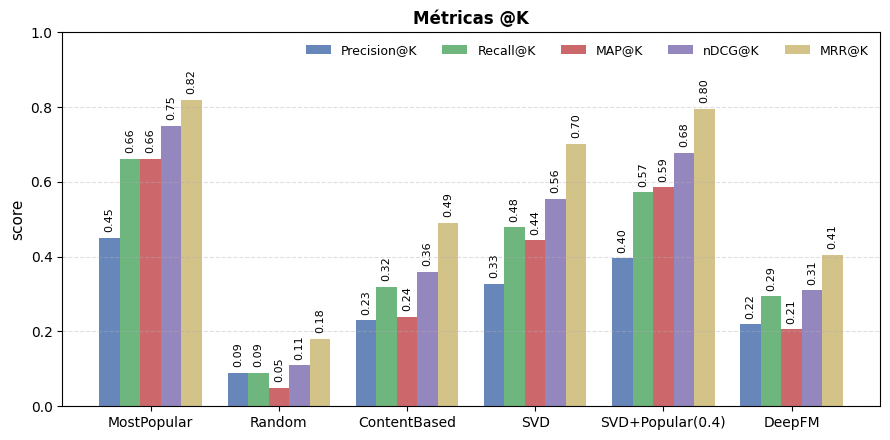

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Corridas previas:
metrics_pop = {
    'Precision@K': 0.45,
    'Recall@K': 0.662,
    'nDCG@K': 0.75,
    'MAP@K': 0.661,
    'MRR@K': 0.82
}

metrics_rand = {
    'Precision@K': 0.09,
    'Recall@K': 0.09,
    'nDCG@K': 0.11,
    'MAP@K': 0.05,
    'MRR@K': 0.18
}

metrics_cb = {
    'Precision@K': 0.23,
    'Recall@K': 0.32,
    'nDCG@K': 0.36,
    'MAP@K': 0.24,
    'MRR@K': 0.49
}

metrics_svd = {
    'Precision@K': 0.32771308604201477,
    'Recall@K': 0.47836745389319163,
    'nDCG@K': 0.5554508181095819,
    'MAP@K': 0.44405094380920956,
    'MRR@K': 0.70211838923753
}

metrics_hybrid = {
    'Precision@K': 0.3961126960312798,
    'Recall@K': 0.5726908110957746,
    'nDCG@K': 0.6776490399389942,
    'MAP@K': 0.5860645982550887,
    'MRR@K': 0.7958669330937532
}

metrics_deepfm = {
    'Precision@K': 0.2192667929496039,
    'Recall@K': 0.2936996061912307,
    'nDCG@K': 0.31049928803150445,
    'MAP@K': 0.2062755017398547,
    'MRR@K': 0.4053540846620946
}

# Resultados ya calculados
results = {
    "MostPopular": metrics_pop,
    "Random": metrics_rand,
    "ContentBased": metrics_cb,
    # "iKNN": metrics_iknn,
    "SVD": metrics_svd,
    "SVD+Popular(0.4)": metrics_hybrid,
    "DeepFM": metrics_deepfm,
}

# construir dataframe para graficar
df_res = pd.DataFrame(results).T[["Precision@K","Recall@K","MAP@K","nDCG@K","MRR@K"]]
metrics_order = ["Precision@K","Recall@K","MAP@K","nDCG@K","MRR@K"]

# Paleta elegante (muted)
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#CCB974"]

plt.figure(figsize=(9,4.5))
x = np.arange(len(df_res))
w = 0.16

for j, (m, c) in enumerate(zip(metrics_order, colors)):
    vals = df_res[m].values
    plt.bar(x + j*w, vals, width=w, label=m, color=c, alpha=0.85)
    for i, v in enumerate(vals):
        plt.text(x[i] + j*w, v + 0.015, f"{v:.2f}", 
                 ha="center", va="bottom", fontsize=8, rotation=90)

plt.xticks(x + w*2, df_res.index, rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.0)
plt.ylabel("score", fontsize=11)
plt.title("Métricas @K", fontsize=12, weight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(ncol=5, fontsize=9, frameon=False)
plt.tight_layout()
plt.savefig("graficos/output.png", dpi=300, bbox_inches="tight")
plt.show()


Comparación diferentes valores de K para SVD + Popular

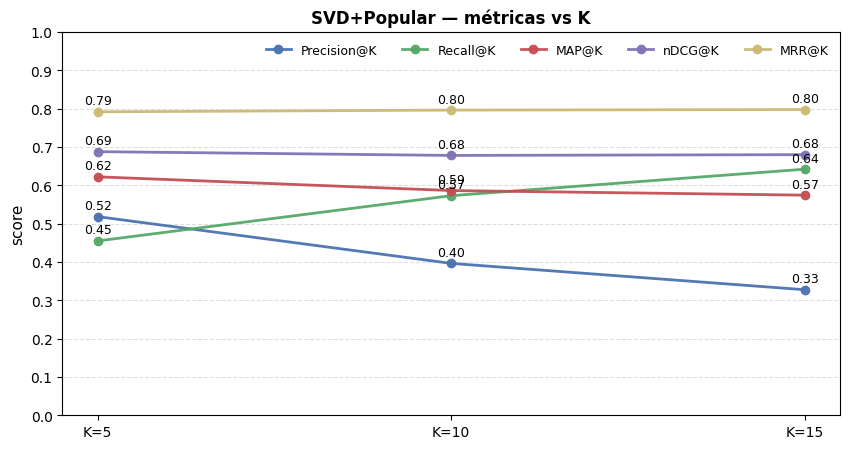

,Precision@K,Recall@K,MAP@K,nDCG@K,MRR@K
5,0.518,0.455,0.622,0.688,0.791
10,0.396,0.573,0.586,0.678,0.796
15,0.327,0.642,0.574,0.680,0.797


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Métricas reportadas para SVD+Popular a distintos K
m_k5  = {'Precision@K': 0.5181266353038506,
         'Recall@K':    0.45469150183606005,
         'nDCG@K':      0.687535689369276,
         'MAP@K':       0.6218567202986139,
         'MRR@K':       0.7913941570613939}

m_k10 = {'Precision@K': 0.3961126960312798,
         'Recall@K':    0.5726908110957746,
         'nDCG@K':      0.6776490399389942,
         'MAP@K':       0.5860645982550887,
         'MRR@K':       0.7958669330937532}

m_k15 = {'Precision@K': 0.3274457470336097,
 'Recall@K': 0.6417936637834316,
 'nDCG@K': 0.6797131549569047,
 'MAP@K': 0.5740422012658681,
 'MRR@K': 0.7973524719830616}

# Construir DataFrame
data = pd.DataFrame(
    [m_k5, m_k10, m_k15],
    index=[5, 10, 15]
)[["Precision@K","Recall@K","MAP@K","nDCG@K","MRR@K"]]

metrics_order = ["Precision@K","Recall@K","MAP@K","nDCG@K","MRR@K"]
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#CCB974"]

plt.figure(figsize=(8.6, 4.6))

x = data.index.values.astype(int)
for c, m, col in zip(range(len(metrics_order)), metrics_order, colors):
    y = data[m].values
    plt.plot(x, y, marker="o", linewidth=2, label=m, color=col, alpha=0.95)
    for xi, yi in zip(x, y):
        plt.text(xi, yi + 0.012, f"{yi:.2f}", ha="center", va="bottom", fontsize=9, rotation=0)

plt.xticks(x, [f"K={k}" for k in x], fontsize=10)
plt.yticks(np.linspace(0, 1.0, 11), fontsize=10)
plt.ylim(0, 1.0)
plt.ylabel("score", fontsize=11)
plt.title("SVD+Popular — métricas vs K", fontsize=12, weight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(ncol=5, fontsize=9, frameon=False)
plt.tight_layout()
plt.savefig("svd_popular_vsK.png", dpi=300, bbox_inches="tight")
plt.show()

display(data.style.format("{:.3f}").set_caption("SVD+Popular — métricas por K"))

# 5. Mejoras en modelos vía Embeddings

Construiremos una matriz única de características (un "embedding" de contenido) para cada ítem (juego) en nuestro dataset. Esta matriz combinará características numéricas (de df_games) y características categóricas/binarias (de los otros CSVs). Esta matriz será la entrada de "contenido" para nuestro modelo híbrido.

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

print("Definiendo funciones para construir la matriz de features de ítem...")

def build_item_feature_matrix(idx2iid, df_games, df_mechanics, df_themes, df_subcategories, df_designers, df_artists, df_publishers):
    """
    Construye una matriz de features de ítem única alineada con el idx2iid del trainset.
    """
    print("Construyendo matriz de features de ítem...")
    n_items = len(idx2iid)
    all_bggids = [idx2iid[i] for i in range(n_items)]
    
    num_cols = ['GameWeight', 'YearPublished', 'MinPlayers', 'MaxPlayers', 'ComMinPlaytime', 'ComMaxPlaytime']
    
    games_num = df_games.set_index('BGGId').reindex(all_bggids)[num_cols].fillna(0).values
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(games_num)
    print(f"  > Features numéricas escaladas: {features_scaled.shape}")

    
    def get_binary_features(df, bggids):
        if 'BGGId' in df.columns:
            df = df.set_index('BGGId')
        return df.reindex(bggids).fillna(0).values

    mech_bin = get_binary_features(df_mechanics, all_bggids)
    print(f"  > Features de mecánicas: {mech_bin.shape}")
    
    themes_bin = get_binary_features(df_themes, all_bggids)
    print(f"  > Features de temas: {themes_bin.shape}")
    
    subcat_bin = get_binary_features(df_subcategories, all_bggids)
    print(f"  > Features de subcategorías: {subcat_bin.shape}")
    
    designers_bin = get_binary_features(df_designers, all_bggids)
    print(f"  > Features de diseñadores: {designers_bin.shape}")
    
    artists_bin = get_binary_features(df_artists, all_bggids)
    print(f"  > Features de artistas: {artists_bin.shape}")
    
    publishers_bin = get_binary_features(df_publishers, all_bggids)
    print(f"  > Features de publishers: {publishers_bin.shape}")

    all_features = np.concatenate([
        features_scaled,
        mech_bin,
        themes_bin,
        subcat_bin,
        designers_bin,
        artists_bin,
        publishers_bin
    ], axis=1)
    
    print(f"Matriz de features creada con shape: {all_features.shape}")
    
    return torch.tensor(all_features, dtype=torch.float)

print("Funciones de features listas.")

In [ ]:
def fm_bi_interaction(feat_embs):
    # feat_embs: [B, F, D] (Batch, N_Features, Dim_Embed)
    sum_feat_embs = feat_embs.sum(dim=1)  # [B, D]
    sum_sq = sum_feat_embs * sum_feat_embs # [B, D]
    
    sq_sum = (feat_embs * feat_embs).sum(dim=1) # [B, D]
    
    bi = 0.5 * (sum_sq - sq_sum).sum(dim=1, keepdim=True) # [B, 1]
    return bi

class DeepFMHybrid(nn.Module):
    def __init__(self, n_users, n_items, n_item_features, emb_dim=32, mlp_layers=(128, 64), dropout=0.2, rating_scale=(1, 10)):
        super().__init__()
        
        self.rmin, self.rmax = rating_scale
        self.span = self.rmax - self.rmin
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim) # Embedding Latente (CF)
        
        self.item_feat_linear = nn.Linear(n_item_features, emb_dim) # Proyección de Features (CB)
        self.item_feat_dropout = nn.Dropout(dropout)
        
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        
        deep_in_dim = emb_dim * 2 # user_emb + item_emb
        layers = []
        prev = deep_in_dim
        for h in mlp_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.deep = nn.Sequential(*layers)
        
        self._init_params()

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def fm_bi_interaction(self, feat_embs):
        sum_feat_embs = feat_embs.sum(dim=1)
        sum_sq = sum_feat_embs * sum_feat_embs
        sq_sum = (feat_embs * feat_embs).sum(dim=1)
        bi = 0.5 * (sum_sq - sq_sum).sum(dim=1, keepdim=True)
        return bi

    def forward(self, u, i, i_feats):
        # u: (B)
        # i: (B)
        # i_feats: (B, N_item_features)
        
        ue = self.user_emb(u) # (B, D)
        
        ie_collab = self.item_emb(i) # (B, D)
        
        ie_content = F.relu(self.item_feat_linear(i_feats)) # (B, D)
        ie_content = self.item_feat_dropout(ie_content)
        
        ie = (ie_collab + ie_content) / 2.0 # (B, D)

        lin = self.global_bias + self.user_bias(u) + self.item_bias(i) # (B, 1)

        feats = torch.stack([ue, ie], dim=1) # (B, 2, D)
        fm = self.fm_bi_interaction(feats) # (B, 1)
        
        deep_in = torch.cat([ue, ie], dim=1) # (B, D*2)
        deep_out = self.deep(deep_in) # (B, 1)
        
        y = lin + fm + deep_out
        
        # Escalamos a (rmin, rmax)
        y = torch.sigmoid(y.squeeze()) * self.span + self.rmin
        
        return y.squeeze()

print("Modelo DeepFMHybrid definido.")

In [ ]:
class DeepFMHybridDataset(Dataset):
    def __init__(self, df, uid2idx, iid2idx, item_features_matrix,
                 user_col="Username", item_col="BGGId", rating_col="Rating"):
        
        self.item_features_matrix = item_features_matrix
        
        df_clean = df.copy()
        df_clean[user_col] = df_clean[user_col].astype(str)
        df_clean[item_col] = df_clean[item_col].astype(str)
        
        mask_valid = (
            df_clean[user_col].notna() & 
            df_clean[item_col].notna() &
            df_clean[user_col].isin(uid2idx.keys()) &
            df_clean[item_col].isin(iid2idx.keys())
        )
        df_clean = df_clean[mask_valid].reset_index(drop=True)
        
        if len(df_clean) < len(df):
            print(f"[DeepFMHybridDataset] Filtrando {len(df) - len(df_clean)} filas inválidas de {len(df)} totales")
        
        self.uval = df_clean[user_col].map(uid2idx).values.astype(np.int64)
        self.ival = df_clean[item_col].map(iid2idx).values.astype(np.int64)
        
        self.yval = df_clean[rating_col].values.astype(np.float32)

    def __len__(self):
        return len(self.yval)

    def __getitem__(self, idx):
        u_idx = self.uval[idx]
        i_idx = self.ival[idx]
        
        i_feat = self.item_features_matrix[i_idx]
        
        y = self.yval[idx]
        
        return u_idx, i_idx, i_feat, y

print("Dataset Híbrido definido.")

def train_deepfm_hybrid(
    train_df,
    item_features_matrix,
    rating_scale=(1, 10),
    user_col="Username",
    item_col="BGGId",
    rating_col="Rating",
    emb_dim=32,
    mlp_layers=(128, 64),
    dropout=0.2,
    lr=2e-3,
    weight_decay=1e-6,
    batch_size=2048,
    epochs=8,
    seed=42,
    device=None,
    log_every=200
):
    print("[DeepFM-Hybrid] Preparando datos y modelo...")
    t0 = time.time()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    uid2idx, iid2idx, idx2uid, idx2iid = build_id_mappings_from_traindf(train_df, user_col, item_col)
    
    ds = DeepFMHybridDataset(train_df, uid2idx, iid2idx, item_features_matrix, user_col, item_col, rating_col)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    item_features_matrix = item_features_matrix.to(device)

    model = DeepFMHybrid(
        n_users=len(uid2idx),
        n_items=len(iid2idx),
        n_item_features=item_features_matrix.shape[1],
        emb_dim=emb_dim,
        mlp_layers=mlp_layers,
        dropout=dropout,
        rating_scale=rating_scale
    ).to(device)
    
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    
    print(f"[DeepFM-Hybrid] Entrenando en {device} (epochs={epochs}, bs={batch_size})...")
    
    for ep in range(1, epochs + 1):
        model.train()
        ep_loss, n, step = 0.0, 0, 0
        ep_t0 = time.time()
        
        for (u, i, i_feat, y) in dl:
            u, i, i_feat, y = u.to(device), i.to(device), i_feat.to(device), y.to(device)
            
            opt.zero_grad()
            pred = model(u, i, i_feat)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            ep_loss += loss.item() * y.size(0)
            n += y.size(0)
            step += 1
            
            if step % log_every == 0:
                print(f"[DeepFM-Hybrid] [ep:{ep}] step:{step} | loss={(ep_loss/n):.4f}")
        
        print(f"[DeepFM-Hybrid] Epoch {ep}/{epochs} | loss={(ep_loss/n):.4f} | tiempo={_fmt_secs(time.time()-ep_t0)}")

    print(f"[DeepFM-Hybrid] Listo en {_fmt_secs(time.time()-t0)}")
    
    state = {
        "model": model.eval(),
        "uid2idx": uid2idx,
        "idx2uid": idx2uid,
        "iid2idx": iid2idx,
        "idx2iid": idx2iid,
        "device": device,
        "rating_scale": rating_scale,
        "item_features_matrix": item_features_matrix
    }
    return state

print("Loop de entrenamiento Híbrido definido.")

@torch.no_grad()
def deepfm_hybrid_topn_from_candidates(state, cands_by_u, n=10, log_every=10000):
    print(f"[DeepFM-Hybrid] Prediciendo sobre candidatos...")
    t0 = time.time()
    
    model = state["model"].eval()
    uid2idx = state["uid2idx"]
    iid2idx = state["iid2idx"]
    device = state["device"]
    item_features_matrix = state["item_features_matrix"]
    
    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)

    batch_u_idx, batch_i_idx = [], []
    batch_uid, batch_iid = [], []

    def flush():
        nonlocal preds, batch_u_idx, batch_i_idx, batch_uid, batch_iid
        if not batch_u_idx:
            return
        
        u_tensor = torch.tensor(batch_u_idx, dtype=torch.long, device=device)
        i_tensor = torch.tensor(batch_i_idx, dtype=torch.long, device=device)
        
        i_feat_tensor = item_features_matrix[i_tensor]
        
        est = model(u_tensor, i_tensor, i_feat_tensor).cpu().numpy().tolist()
        
        for uid, iid, est_val in zip(batch_uid, batch_iid, est):
            preds.append((uid, iid, None, float(est_val), {}))
            
        batch_u_idx.clear(); batch_i_idx.clear(); batch_uid.clear(); batch_iid.clear()

    for idx, uid in enumerate(users, 1):
        uidx = uid2idx.get(str(uid), None)
        if uidx is None:
            continue
            
        if idx % log_every == 0:
            print(f"[DeepFM-Hybrid] Predicción: {idx}/{total_u} ({idx/total_u:.1%}) | ETA {_eta(t0, idx, total_u)}")

        for iid in cands_by_u[uid]:
            iidx = iid2idx.get(str(iid), None)
            if iidx is None:
                continue
                
            batch_u_idx.append(uidx)
            batch_i_idx.append(iidx)
            batch_uid.append(uid)
            batch_iid.append(iid)
            
            if len(batch_u_idx) >= 65_536:
                flush()
    flush()
    
    print(f"[DeepFM-Hybrid] Predicción: {_fmt_secs(time.time()-t0)}")
    
    t1 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[DeepFM-Hybrid] Top-N: {_fmt_secs(time.time()-t1)}")
    return topn

print("Loop de predicción Híbrido definido.")

In [ ]:
print("Generando mapeos para la matriz de features...")
_, _, _, idx2iid_full = build_id_mappings_from_traindf(train_df, "Username", "BGGId")

item_features_matrix = build_item_feature_matrix(
    idx2iid_full, 
    df_games, 
    df_mechanics, 
    df_themes, 
    df_subcategories, 
    df_designers_reduced, 
    df_artists_reduced, 
    df_publishers_reduced
)

deepfm_hybrid_state = train_deepfm_hybrid(
    train_df,
    item_features_matrix,
    rating_scale=(1, 10),
    emb_dim=32,
    mlp_layers=(128, 64),
    dropout=0.2,
    lr=2e-3,
    weight_decay=1e-6,
    batch_size=9216,
    epochs=8,
    seed=42
)

topn_deepfm_hybrid = deepfm_hybrid_topn_from_candidates(
    deepfm_hybrid_state, 
    cands, 
    n=10
)

metrics_deepfm_hybrid = precision_recall_ndcg_map_mrr_at_k(
    topn_deepfm_hybrid, 
    heldout, 
    k=10
)

print("\n--- Métricas DeepFM Híbrido (con Features) ---")
print(metrics_deepfm_hybrid)



results["DeepFM+Features"] = metrics_deepfm_hybrid

df_res = pd.DataFrame(results).T[["Precision@K", "Recall@K", "MAP@K", "nDCG@K", "MRR@K"]]
metrics_order = ["Precision@K", "Recall@K", "MAP@K", "nDCG@K", "MRR@K"]

colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#CCB974"]

plt.figure(figsize=(12, 6))
x = np.arange(len(df_res))
w = 0.16

for j, (m, c) in enumerate(zip(metrics_order, colors)):
    vals = df_res[m].values
    plt.bar(x + j*w, vals, width=w, label=m, color=c, alpha=0.85)
    for i, v in enumerate(vals):
        plt.text(x[i] + j*w, v + 0.015, f"{v:.2f}", 
                 ha="center", va="bottom", fontsize=8, rotation=90)

plt.xticks(x + w*2, df_res.index, rotation=0, fontsize=10)
plt.ylim(0, 1.0)
plt.ylabel("score", fontsize=11)
plt.title("Comparación de Modelos (incl. Híbrido) — métricas @K", fontsize=12, weight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(ncol=5, fontsize=9, frameon=False)
plt.tight_layout()
plt.show()